In [1]:
import sys
import os
import pandas as pd

from transformers.trainer_pt_utils import log_metrics

In [2]:
import torch
import torch.nn as nn

In [3]:
sys.path.append(os.path.abspath("../.."))
from utils import read_features, read_targets, print_info_features, print_info_targets, train_val_split, get_dimensions, \
    scale, \
    metrics_r, get_device, plot_history, load_best_params, print_best_params_nn, fmt_time

In [4]:
sys.path.append(os.path.abspath(".."))
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, train, tune

## Set Working Device

In [5]:
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


## Read Features and Targets

In [6]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/chronology_prediction"))

In [7]:
targets = ["StartYear", "YearRange"]

In [8]:
X = read_features(path, f_type="tensors")
y = read_targets(path, targets, f_type="np")

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


## Train-Validation Split

In [9]:
X, y = train_val_split(X, y)

## Scale Regression Targets

In [10]:
y, y_scaler = scale(y)

In [11]:
y = {subset: torch.tensor(_y, dtype=torch.float32, device=device) for subset, _y in y.items()}

## Dimensions

In [12]:
X_dim, y_dim = get_dimensions(X, y)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 2


## Torch Datasets and Dataloaders

In [13]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

## Tune Model



In [14]:
path_params = "best_params.json"
path_history = "tuning_history.csv"

best_params = load_best_params(path_params)
print(f"Best Params Available for {len(best_params.keys())} Models")

tuning_histories = pd.read_csv(path_history)
tuning_histories = {model_ft: model_ft_history.drop(columns='model_feature_type')
                    for model_ft, model_ft_history in tuning_histories.groupby('model_feature_type')}


Best Params Available for 1 Models


In [15]:
tuning_histories

{'tfidf':     activation  blocks  dropout  hidden_size hidden_size_pattern      lr  \
 0         relu       3      0.1          256          decreasing  0.0010   
 1         relu       3      0.1          256          decreasing  0.0010   
 2         relu       3      0.1          256          decreasing  0.0001   
 3         relu       3      0.1          256          decreasing  0.0001   
 4         relu       3      0.1          256            constant  0.0010   
 ..         ...     ...      ...          ...                 ...     ...   
 187       gelu      10      0.3          512          decreasing  0.0001   
 188       gelu      10      0.3          512            constant  0.0010   
 189       gelu      10      0.3          512            constant  0.0010   
 190       gelu      10      0.3          512            constant  0.0001   
 191       gelu      10      0.3          512            constant  0.0001   
 
      weight_decay  train_loss  val_loss      mae_0      mae_1   

In [16]:
criterion = nn.MSELoss()
metrics = metrics_r

param_grid = {
    # Architecture Params
    # "hidden_size": [128, 256, 512, 1024],
    "hidden_size": [256, 512],
    "activation": ["relu", "gelu"],
    # "dropout": [0, 0.1, 0.3, 0.5],
    "dropout": [0.1, 0.3],
    # "blocks": [1, 2, 3, 5, 10],
    "blocks": [3, 5, 10],
    "hidden_size_pattern": ["decreasing", "constant"],

    # Training Params
    # "lr": [1e-2, 1e-3, 1e-4, 1e-5],
    "lr": [1e-3, 1e-4],
    # "weight_decay": [1e-5, 1e-6, 1e-7],
    "weight_decay": [1e-5, 1e-6],
}

In [17]:
for ft in feature_types:
    if ft not in ["tfidf", "bert"]: continue
    log_metrics = ["mae"]
    if ft not in best_params.keys():
        print(f"\n🔄 Tuning MLP with '{ft.upper()}' Features")
        tuning_result, tuning_history = tune(
            param_grid,
            [X_dim[ft]],
            y_dim,
            loaders["train"][ft],
            loaders["val"][ft],
            criterion,
            metrics,
            device,
            y_scaler,
            log_metrics=log_metrics,
            chronology_target="years"
        )

        best_params[ft] = tuning_result
        tuning_histories[ft] = tuning_history
    else:
        print(f"\n✅ MLP with '{ft.upper()}' Features Already Tuned. Execution Time: {fmt_time(best_params[ft]["time"])}")
        print_best_params_nn(best_params[ft], param_grid, y_dim, log_metrics)


    # tuning_history.insert(0, 'model_feature_type', ft)
    # tuning_histories += [tuning_history]

for ft_txt, ft_img in feature_type_combos:
    if True: break
    ft = ft_txt + " + " + ft_img
    tuning_result, tuning_history = tune(
        param_grid,
        [X_dim[ft_txt], X_dim[ft_img]],
        y_dim,
        loaders["train"][ft],
        loaders["val"][ft],
        criterion,
        metrics,
        device,
        y_scaler,
        log_metrics=["mae"],
        chronology_target="years"
    )

    best_params[ft] = tuning_result
    tuning_histories[ft] = tuning_history



✅ MLP with 'TFIDF' Features Already Tuned. Execution Time: 2m 42s
+-----------+-------------+------------+---------+--------+---------------------+--------+--------------+-----------+-----------+-----------+
| combo_idx | hidden_size | activation | dropout | blocks | hidden_size_pattern |     lr | weight_decay |  val_loss |     mae_0 |     mae_1 |
+-----------+-------------+------------+---------+--------+---------------------+--------+--------------+-----------+-----------+-----------+
|      BEST |         256 |       relu |     0.1 |      3 |            constant | 0.0001 |        1e-05 |    0.6734 |   37.8979 |   10.3946 |
+-----------+-------------+------------+---------+--------+---------------------+--------+--------------+-----------+-----------+-----------+

🔄 Tuning MLP with 'BERT' Features
+-----------+-------------+------------+---------+--------+---------------------+--------+--------------+-----------+-----------+-----------+
| combo_idx | hidden_size | activation | dropo

## Save Best Params And Tunning History

In [18]:
import json

with open("best_params.json", "w") as f:
    json.dump(best_params, f, indent=2)

In [19]:
tuning_history_full = pd.concat([
    tuning_history.assign(model_feature_type = ft)
    for ft, tuning_history in tuning_histories.items()],
    axis=0,
    ignore_index=True
)
tuning_history_full.to_csv("tuning_history.csv", index=False)

## Evaluate Tuning Results

In [17]:
tuning_history.sort_values("val_loss").head(100)

,model_feature_type,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
6,tfidf,relu,3,0.1,256,constant,0.0001,0.000010,0.535051,0.673395,37.897888,10.394637,49.049648,12.530911,0.518437,0.220022,30.885895,9.884153
16,tfidf,relu,3,0.3,256,decreasing,0.0010,0.000010,0.424977,0.674614,36.333660,10.254250,48.812275,12.687943,0.523087,0.200351,24.201096,9.750834
37,tfidf,relu,5,0.1,256,constant,0.0010,0.000001,0.505277,0.675162,37.500370,9.999688,50.133366,12.458893,0.496923,0.228962,28.922470,9.386595
61,tfidf,relu,5,0.3,512,constant,0.0010,0.000001,0.335512,0.677176,36.731995,10.060456,48.677925,12.648464,0.525709,0.205320,25.046646,8.332052
40,tfidf,relu,5,0.1,512,decreasing,0.0010,0.000010,0.567338,0.679778,37.561390,10.449737,49.335926,12.637841,0.512800,0.206654,28.611115,10.322656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,tfidf,gelu,3,0.3,512,constant,0.0010,0.000001,0.626218,0.733438,41.825733,10.524571,53.251682,12.854306,0.432393,0.179244,32.018127,9.968676
96,tfidf,gelu,3,0.1,256,decreasing,0.0010,0.000010,0.614690,0.733868,41.485657,10.450378,53.114754,12.816572,0.435308,0.184056,33.548065,9.704582
32,tfidf,relu,5,0.1,256,decreasing,0.0010,0.000010,0.422361,0.734322,38.410557,10.636481,51.496433,13.033273,0.469195,0.156231,25.527435,8.617987
97,tfidf,gelu,3,0.1,256,decreasing,0.0010,0.000001,0.608333,0.734491,41.010803,10.435335,53.303040,12.745529,0.431298,0.193076,31.684479,10.116903


In [18]:
tuning_history.sort_values("mae_0").head()

,model_feature_type,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
77,tfidf,relu,10,0.1,512,constant,0.001,0.000001,0.587959,0.783241,35.633152,12.075846,50.022308,14.177215,0.499149,0.001614,23.177200,9.438070
16,tfidf,relu,3,0.3,256,decreasing,0.001,0.000010,0.424977,0.674614,36.333660,10.254250,48.812275,12.687943,0.523087,0.200351,24.201096,9.750834
56,tfidf,relu,5,0.3,512,decreasing,0.001,0.000010,0.375253,0.698727,36.401775,10.421831,48.875076,12.948037,0.521859,0.167231,24.263092,9.298313
57,tfidf,relu,5,0.3,512,decreasing,0.001,0.000001,0.318203,0.689376,36.419910,10.274539,49.200333,12.813963,0.515474,0.184388,22.742340,8.465163
45,tfidf,relu,5,0.1,512,constant,0.001,0.000001,0.245153,0.696772,36.478146,10.518407,48.299614,13.046271,0.533052,0.154547,26.462692,8.540536


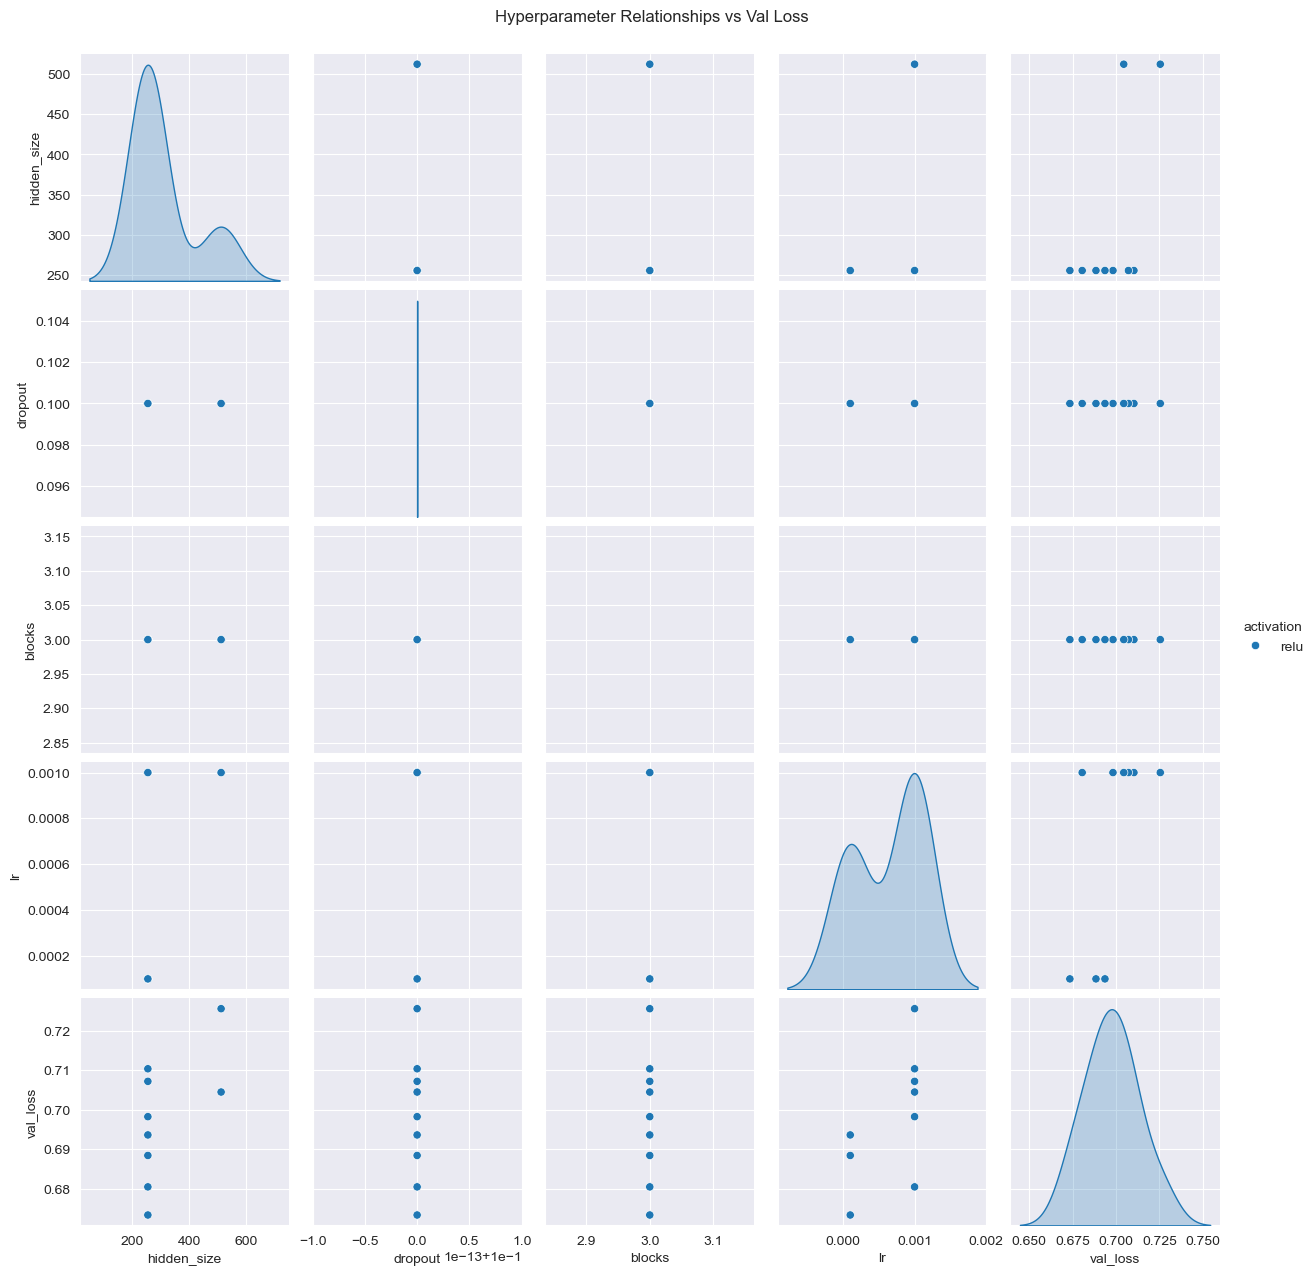

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(
    tuning_histories["tfidf"].head(10),
    vars=["hidden_size", "dropout", "blocks", "lr", "val_loss"],
    hue="activation",
    diag_kind="kde",
)
plt.suptitle("Hyperparameter Relationships vs Val Loss", y=1.02)
plt.show()


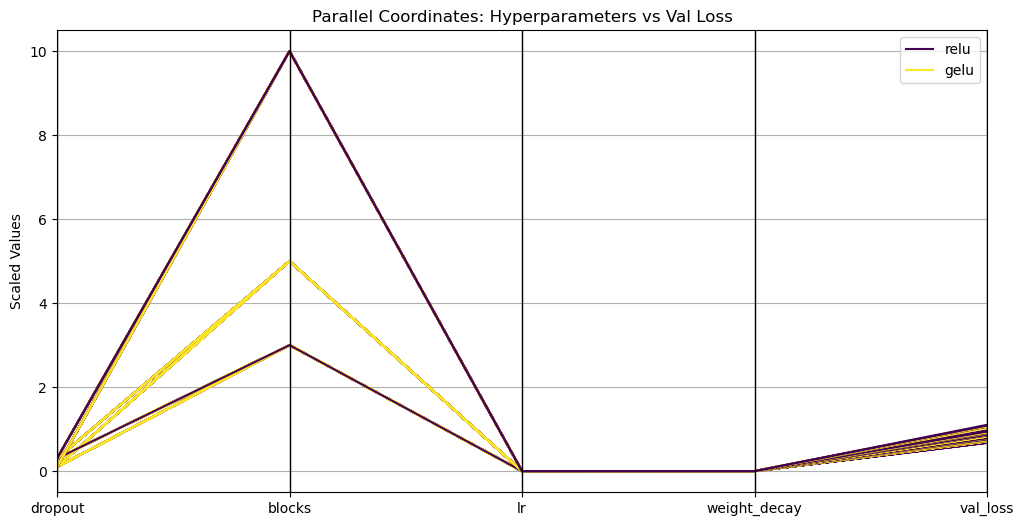

In [26]:
from pandas.plotting import parallel_coordinates

cols = ["activation", "dropout", "blocks", "lr", "weight_decay", "val_loss"]
plt.figure(figsize=(12,6))
parallel_coordinates(tuning_histories[0][cols].sort_values("val_loss"), class_column="activation", colormap="viridis")
plt.title("Parallel Coordinates: Hyperparameters vs Val Loss")
plt.ylabel("Scaled Values")
plt.show()


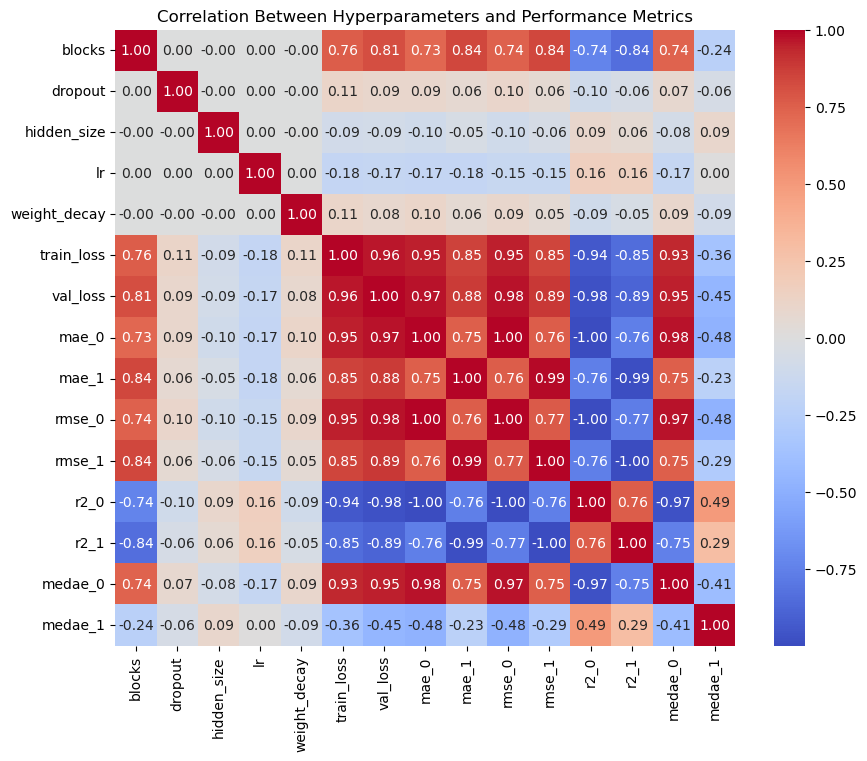

In [27]:
numeric_cols = tuning_histories[0].select_dtypes(include=["number"])
plt.figure(figsize=(10,8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Hyperparameters and Performance Metrics")
plt.show()


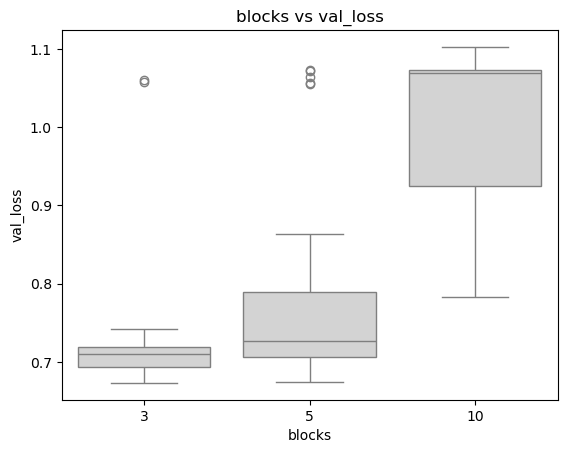

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=tuning_histories[0], x='blocks', y='val_loss', alpha=0.7)
sns.boxplot(data=tuning_histories[0], x='blocks', y='val_loss', color='lightgray')
plt.title("blocks vs val_loss")
plt.show()


In [40]:
from utils import metrics_c
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tuning_results(results, param_grid, topN=10, global_norm=True):
    """
    Display top-N parameter combinations from hyperparameter tuning with color gradients.
    """
    # Convert to DataFrame if needed
    df = pd.DataFrame(results).copy()

    # Sort by val loss
    sort_col = "val_loss" if "val_loss" in df.columns else df.columns[df.columns.str.contains("val", case=False)][0]
    df = df.sort_values(sort_col, ascending=True).reset_index(drop=True)
    df_top = df.head(topN).reset_index(drop=True)

    # Identify groups
    param_cols = list(param_grid.keys())
    loss_cols = [c for c in df.columns if "loss" in c.lower()]
    metric_cols = [c for c in df.columns if any(m in c.lower() for m in metrics_r | metrics_c)]

    # Detect numeric vs categorical safely
    num_cols, cat_cols = [], []
    for col in param_cols:
        # If column is numeric dtype OR all values can be cast to float safely
        try:
            _ = df[col].astype(float)
            num_cols.append(col)
        except (ValueError, TypeError):
            cat_cols.append(col)

    # Color maps
    color_maps = {
        "params": "YlGnBu",
        "categorical": sns.color_palette("Set3", as_cmap=True),
        "loss": "RdYlBu_r",
        "metrics": "Greens"
    }

    # Pick normalization base
    norm_df = df if global_norm else df_top

    # Styler setup
    styler = df_top.style.format(precision=4)

    # Sequential colormap for numeric params
    for col in num_cols:
        styler = styler.background_gradient(
            cmap=color_maps["params"],
            subset=[col],
            vmin=norm_df[col].min(),
            vmax=norm_df[col].max()
        )

    # Qualitative colors for categorical params
    if cat_cols:
        # Generate distinct colors for each category value
        palette = sns.color_palette("Set3", n_colors=max(3, len(cat_cols) * 3))
        cat_colors = {val: palette[i % len(palette)] for i, val in enumerate(pd.unique(df[cat_cols].values.ravel()))}

        def color_cat(val):
            return f"background-color: rgb({int(cat_colors[val][0]*255)}, {int(cat_colors[val][1]*255)}, {int(cat_colors[val][2]*255)})"

        for col in cat_cols:
            styler = styler.map(color_cat, subset=[col])

    # Diverging colormap for losses (lower = better)
    for col in loss_cols:
        styler = styler.background_gradient(
            cmap=color_maps["loss"],
            subset=[col],
            vmin=norm_df[col].min(),
            vmax=norm_df[col].max()
        )

    # Sequential colormap for metrics (higher = better)
    for col in metric_cols:
        styler = styler.background_gradient(
            cmap=color_maps["metrics"],
            subset=[col],
            vmin=norm_df[col].min(),
            vmax=norm_df[col].max()
        )

    # Highlight best row
    styler = styler.highlight_min(subset=[sort_col], color="lightgreen")

    # Style adjustments
    styler.set_properties(**{
        'text-align': 'center',
        'font-size': '14px'
    })

    styler.set_table_styles([
        {'selector': 'th', 'props': [('font-size', '14px'), ('text-align', 'center')]}
    ])

    display(styler)


In [42]:
plot_tuning_results(tuning_histories[0], param_grid, global_norm=False)

,model_feature_type,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,weight_decay,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
0,tfidf,relu,3,0.1000,256,constant,0.0001,0.0000,0.5351,0.6734,37.8979,10.3946,49.0496,12.5309,0.5184,0.2200,30.8859,9.8842
1,tfidf,relu,3,0.3000,256,decreasing,0.0010,0.0000,0.4250,0.6746,36.3337,10.2542,48.8123,12.6879,0.5231,0.2004,24.2011,9.7508
2,tfidf,relu,5,0.1000,256,constant,0.0010,0.0000,0.5053,0.6752,37.5004,9.9997,50.1334,12.4589,0.4969,0.2290,28.9225,9.3866
3,tfidf,relu,5,0.3000,512,constant,0.0010,0.0000,0.3355,0.6772,36.7320,10.0605,48.6779,12.6485,0.5257,0.2053,25.0466,8.3321
4,tfidf,relu,5,0.1000,512,decreasing,0.0010,0.0000,0.5673,0.6798,37.5614,10.4497,49.3359,12.6378,0.5128,0.2067,28.6111,10.3227
5,tfidf,relu,5,0.3000,512,constant,0.0010,0.0000,0.4635,0.6800,37.5470,10.2964,49.8535,12.5984,0.5025,0.2116,25.8309,10.2403
6,tfidf,relu,3,0.1000,256,constant,0.0010,0.0000,0.4247,0.6805,37.3014,10.1844,49.7077,12.5897,0.5054,0.2127,28.5868,8.9685
7,tfidf,relu,5,0.1000,256,constant,0.0010,0.0000,0.3649,0.6831,38.6182,10.2007,51.3804,12.4283,0.4716,0.2327,28.9188,10.5069
8,tfidf,relu,5,0.1000,512,constant,0.0001,0.0000,0.4416,0.6836,38.4655,10.5131,49.6406,12.6082,0.5068,0.2104,29.7659,9.2003
9,tfidf,relu,3,0.3000,256,decreasing,0.0010,0.0000,0.4934,0.6853,36.5404,10.3282,49.1616,12.7274,0.5162,0.1954,25.0332,9.4593
